In [4]:
import torch
import lovely_tensors as lt
lt.monkey_patch()

from datasets import load_dataset

from datetime import datetime
print(datetime.now())



2025-07-10 11:05:47.224046


# Objectives
1. Obtain a standard text dataset from huggingface
2. Code up a loss function.
3. Bring parity with torch's built-in loss functions.

In [5]:
data_hf = load_dataset("google-research-datasets/go_emotions")
data_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [14]:
labels = data_hf['train'].features['labels'].feature.names
print(len(labels))
{i:l for i, l in enumerate(labels)}

28


{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

In [18]:
# Doing a multi-class classification problem for now
train_y = [x[0] for x in data_hf['train']['labels']]
val_y   = [x[0] for x in data_hf['validation']['labels']]
test_y  = [x[0] for x in data_hf['test']['labels']]

# Text Processor

In [21]:
# Text preprocessing and tokenization
from collections import Counter
import numpy as np

class TextDataProcessor:
    def __init__(self, vocab_size=10000, max_length=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_built = False
        
    def build_vocab(self, texts):
        """Build vocabulary from training texts"""
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)
        
        # Keep most frequent words
        most_common = word_counts.most_common(self.vocab_size - 2)  # -2 for PAD and UNK
        
        # Build mappings
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        
        for i, (word, _) in enumerate(most_common, start=2):
            self.word_to_idx[word] = i
            self.idx_to_word[i] = word
            
        self.vocab_built = True
        
    def text_to_indices(self, text):
        """Convert text to sequence of indices"""
        words = text.lower().split()
        indices = []
        for word in words:
            idx = self.word_to_idx.get(word, 1)  # 1 is UNK token
            indices.append(idx)
        
        # Pad or truncate to max_length
        if len(indices) < self.max_length:
            indices.extend([0] * (self.max_length - len(indices)))
        else:
            indices = indices[:self.max_length]
            
        return indices

# Process the go_emotions dataset
processor = TextDataProcessor(vocab_size=5000, max_length=16)

# Extract texts from training set
train_texts = [example['text'] for example in data_hf['train']]
processor.build_vocab(train_texts)

print(f"Vocabulary size: {len(processor.word_to_idx)}")
print(f"Sample vocab: {list(processor.word_to_idx.items())[:10]}")

# Convert texts to indices
train_sequences = [processor.text_to_indices(text) for text in train_texts]
val_sequences = [processor.text_to_indices(text) for text in data_hf['validation']['text']]
test_sequences = [processor.text_to_indices(text) for text in data_hf['test']['text']]

# Convert to tensors
train_X = torch.tensor(train_sequences)
val_X = torch.tensor(val_sequences)
test_X = torch.tensor(test_sequences)

# Get labels (multi-label classification)
train_y = torch.tensor(train_y)
val_y = torch.tensor(val_y)
test_y = torch.tensor(test_y)

print(f"Train shape: {train_X.shape}, {train_y.shape}")
print(f"Val shape: {val_X.shape}, {val_y.shape}")
print(f"Test shape: {test_X.shape}, {test_y.shape}")

Vocabulary size: 5000
Sample vocab: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('i', 3), ('to', 4), ('a', 5), ('and', 6), ('you', 7), ('is', 8), ('that', 9)]
Train shape: torch.Size([43410, 16]), torch.Size([43410])
Val shape: torch.Size([5426, 16]), torch.Size([5426])
Test shape: torch.Size([5427, 16]), torch.Size([5427])


# Data loaders for our training loop

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [27]:
for X, y in train_dataloader:
    print(X.v, y.v)
    break

tensor[8, 16] i64 n=128 (1Kb) x∈[0, 4576] μ=326.953 σ=864.634
tensor([[  17, 1225,  708,    8,  225,    3,  133,   24,    4,    1, 1323,    0,
            0,    0,    0,    0],
        [  95,   32,   30,  164,  166,    1,  197,   64,   55, 1226,  238,    5,
          571, 4177,   27,   49],
        [  84,    2,  203,    8,    1,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   4,  102,   68,  107,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [1877, 3333,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 418,    1,  222,   50,  271,    4,  235,  172,   14,    2,    1, 2035,
         4575,  659,    1, 4576],
        [ 303,    3,  316,    1,    2, 2187,    1,    9,   65,    4,   19, 2525,
           89,   15,   29,    1],
        [  43,  123,   61,    1,    6,    4, 1501,    5,  346,   61, 1129,   15,
          101,  110, 2960,   19]]) tensor[8] i64 x∈[

# Multi-class classification model definition

In [32]:
class EmbeddingClassifier(torch.nn.Module):
    def __init__(self, embedding_size, embedding_dim, dropout_rate, hidden_dim, num_classes):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=embedding_size, embedding_dim=embedding_dim, padding_idx=0) #what is padding idx?
        self.dropout1 = torch.nn.Dropout(p=dropout_rate)
        self.linear1 = torch.nn.Linear(embedding_dim, hidden_dim, bias=True)
        self.dropout2 = torch.nn.Dropout(p=dropout_rate)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, num_classes, bias=True)

    def forward(self, batch_x):
        x = self.embedding(batch_x) # shape: (batch_size, sequence_len, embedding_dim)
        x = self.dropout1(x) # shape: (batch_size, sequence_len, embedding_dim)
        
        # mean pooling across sequence dimension
        x = x.mean(dim=1) # shape: (batch_size, embedding_dim)
        x = self.linear1(x) # shape: (batch_size, hidden_dim)
        x = self.dropout2(x) # shape: (batch_size, hidden_dim)
        x = self.relu(x) # shape: (batch_size, hidden_dim)
        x = self.linear2(x) # shape: (batch_size, num_classes)
        return x

torch.manual_seed(42)
model = EmbeddingClassifier(embedding_size=5000, embedding_dim=32, dropout_rate=0.5, hidden_dim=5, num_classes=28)
model
print([p.numel() for p in model.parameters()])

[160000, 160, 5, 140, 28]


In [86]:
# from torchinfo import summary

# summary(model, input_size=(1,))

# Multi-class classification model training

In [81]:
n_epochs = 20

train_losses = []
val_losses = []
train_wnorms = []
train_gnorms = []

torch.manual_seed(42)
model = EmbeddingClassifier(embedding_size=5000, embedding_dim=32, dropout_rate=0.5, hidden_dim=5, num_classes=28)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for i in range(n_epochs):

    total_train_loss = 0.0
    total_train_batches = 0

    for b_X, b_y in train_dataloader:
        # forward pass
        train_logits = model(b_X)

        # backward pass
        optimizer.zero_grad()
        loss = criterion(train_logits, b_y)

        loss.backward()
        
        # weight updates
        optimizer.step()

        total_train_loss += loss.item()
        total_train_batches += 1

        # logging diagnostics
        all_wparams = torch.cat([x.data.view(-1) for x in model.parameters()])
        all_gparams = torch.cat([x.grad.view(-1) for x in model.parameters()])
        wnorm = all_wparams.norm().item()
        gnorm = all_gparams.norm().item()

        train_wnorms.append(wnorm)
        train_gnorms.append(gnorm)

    avg_train_loss = total_train_loss / total_train_batches
    train_losses.append(avg_train_loss)

    total_val_loss = 0.0
    total_val_batches = 0
    with torch.no_grad():
        for b_X, b_y in val_dataloader:
            logits = model(b_X)
            val_loss = criterion(logits, b_y)

            total_val_loss += val_loss.item()
            total_val_batches +=1
    
    avg_val_loss = total_val_loss / total_val_batches
    val_losses.append(avg_val_loss)

    print(f"epoch: {i:03d}/{n_epochs:03d} | train_loss: {avg_train_loss:4f} | val_loss: {avg_val_loss:3f}")


epoch: 000/020 | train_loss: 2.931280 | val_loss: 2.785795
epoch: 001/020 | train_loss: 2.749333 | val_loss: 2.735700
epoch: 002/020 | train_loss: 2.720167 | val_loss: 2.712663
epoch: 003/020 | train_loss: 2.700190 | val_loss: 2.690259
epoch: 004/020 | train_loss: 2.684238 | val_loss: 2.681761
epoch: 005/020 | train_loss: 2.670826 | val_loss: 2.669599
epoch: 006/020 | train_loss: 2.654591 | val_loss: 2.653177
epoch: 007/020 | train_loss: 2.642230 | val_loss: 2.636552
epoch: 008/020 | train_loss: 2.628418 | val_loss: 2.626567
epoch: 009/020 | train_loss: 2.612797 | val_loss: 2.610199
epoch: 010/020 | train_loss: 2.605967 | val_loss: 2.598433
epoch: 011/020 | train_loss: 2.597314 | val_loss: 2.590166
epoch: 012/020 | train_loss: 2.583689 | val_loss: 2.600784
epoch: 013/020 | train_loss: 2.578484 | val_loss: 2.584969
epoch: 014/020 | train_loss: 2.573356 | val_loss: 2.575853
epoch: 015/020 | train_loss: 2.565800 | val_loss: 2.562554
epoch: 016/020 | train_loss: 2.561173 | val_loss: 2.5614

In [80]:
model.embedding.weight.view(-1).norm().item()

406.9892272949219

# Model diagnostics

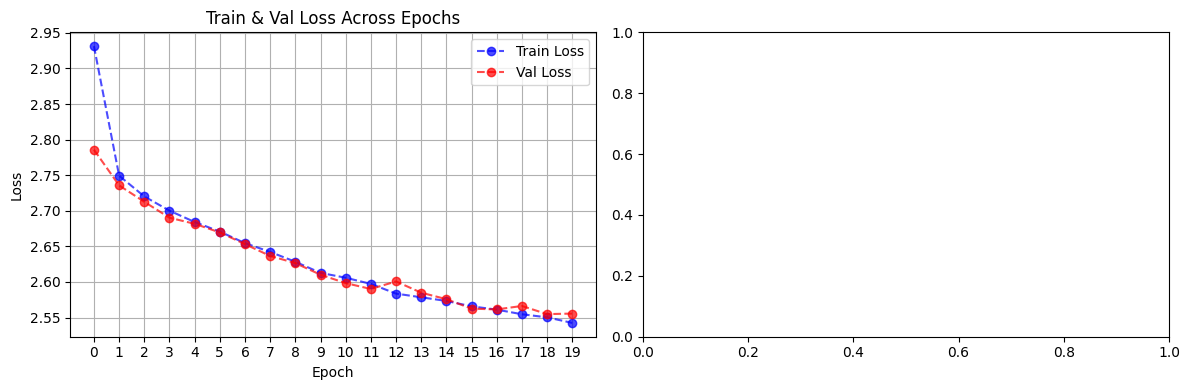

In [ ]:
# copied over from older codebase

import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, train_losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
# axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# todo across steps and not epochs
# Plot gradient norms
# axes[1].scatter(epochs, train_gnorms, color='green')
# axes[1].plot(epochs, train_gnorms, linestyle='dashed', alpha=0.5)
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Norm of Grad Parameters')
# axes[1].set_title('Norm of Grad Parameters Across Epochs')
# axes[1].set_xticks(epochs)
# axes[1].set_ylim(bottom=0)  # Start y-axis from zero
# axes[1].grid(True)

plt.tight_layout()
plt.show()


In [87]:
datetime.now()

datetime.datetime(2025, 7, 10, 13, 4, 39, 429049)